In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_BookCrossing'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(390999, 18)

In [12]:
bs=64

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(77805, 185973)

In [16]:
len(dltrain)

6110

In [17]:
6110*64

391040

## Model Architecture

In [43]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.3

In [44]:
n_users

77805

In [45]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.sigmoid=nn.Sigmoid()
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [46]:
n_users

77805

In [47]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [48]:
cfobj

cf(
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [24]:
for Xb, Yb in dltrain:
    break

In [25]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [26]:
cfobj.forward(Xb,Yb)

(tensor([[8.8270],
         [9.9202],
         [5.4173],
         [4.7409],
         [9.8208],
         [7.1623],
         [9.9233],
         [9.8856],
         [6.3384],
         [2.0255],
         [6.1767],
         [3.0986],
         [8.3917],
         [1.6828],
         [6.1703],
         [9.7411],
         [8.3425],
         [1.1169],
         [2.7761],
         [1.7978],
         [4.9592],
         [2.5384],
         [1.3196],
         [6.8220],
         [2.8342],
         [9.5944],
         [4.0379],
         [7.2139],
         [5.8359],
         [3.8191],
         [1.6540],
         [2.4815],
         [6.8652],
         [2.4521],
         [2.6542],
         [8.4804],
         [4.6031],
         [1.5684],
         [6.8725],
         [4.7267],
         [9.7392],
         [1.2440],
         [3.6794],
         [2.8350],
         [7.5125],
         [5.3284],
         [4.6793],
         [1.8182],
         [8.2817],
         [4.1682],
         [3.1956],
         [2.9569],
         [6.

## Learner

In [49]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} ')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [50]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [51]:
device='cuda:1'

In [52]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [53]:
cfobj=cfobj.to(device)

In [54]:
cfobj

cf(
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [55]:
len(dltrain)

6110

In [56]:
wd=5e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,10000,0.25,cycle_mult=0)

In [57]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

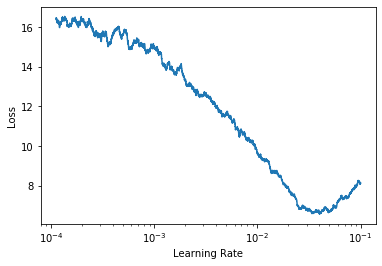

In [58]:
learner.plot_lrs(100)

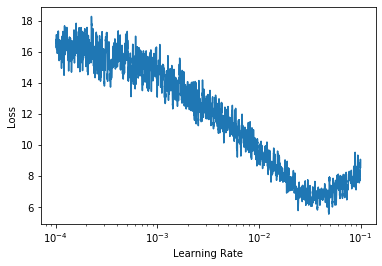

In [59]:
learner.plot_lrs(10)

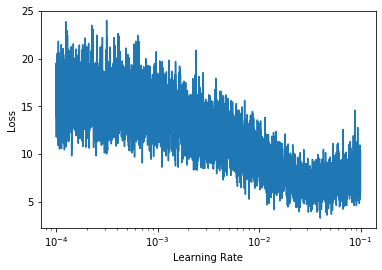

In [60]:
learner.plot_lrs(1)

In [68]:
del cfobj
torch.cuda.empty_cache()

In [69]:
wd=5e-5
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [70]:
device

'cuda:1'

In [71]:
optimizer=torch.optim.AdamW(cfobj.parameters(),lr=9e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0,start_lr=9e-3,end_lr=3e-3,wd_mult=1.2)

In [72]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.009 Weight Decay 5e-05 Train Loss:12.461294905682827                 Valid Loss:9.166106748080503 Train RMSE:3.51074267955355 Valid RMSE:2.994079231376929 
Epoch:1 Learning rate 0.009 Weight Decay 5e-05 Train Loss:7.928338478083696                 Valid Loss:8.616941515831039 Train RMSE:2.802557652132893 Valid RMSE:2.899206916613839 


In [66]:
wd=6e-5
optimizer=torch.optim.SGD(cfobj.parameters(),lr=7e-3,momentum=0.9, weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0,start_lr=9e-3,end_lr=3e-3,wd_mult=1.2)

In [67]:
learner.run_epochs(dltrain,dlvalid,4)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:3.3689884840173923                 Valid Loss:3.649019640961151 Train RMSE:1.8275922512716678 Valid RMSE:1.8913464169348484 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:3.205413356447766                 Valid Loss:3.640102693523424 Train RMSE:1.7828551955874201 Valid RMSE:1.8890880634981568 
Epoch:2 Learning rate 0.007 Weight Decay 6e-05 Train Loss:3.0981105888338605                 Valid Loss:3.6300027188153816 Train RMSE:1.7525515202883777 Valid RMSE:1.8864225215893329 
Epoch:3 Learning rate 0.007 Weight Decay 6e-05 Train Loss:3.013436867777142                 Valid Loss:3.6280878530270693 Train RMSE:1.7284659338719772 Valid RMSE:1.886060000941839 


In [43]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.9965628144588876                 Valid Loss:3.420152141951371 Train RMSE:1.4053340806931225 Valid RMSE:1.8278362491967692 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.926850448243942                 Valid Loss:3.414186795254697 Train RMSE:1.3806394889856612 Valid RMSE:1.8262672653188046 


In [44]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.8646866243716738                 Valid Loss:3.4126790865607886 Train RMSE:1.3584024963435721 Valid RMSE:1.8259784263630972 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.8172519211585705                 Valid Loss:3.4088786654565286 Train RMSE:1.3408275255344628 Valid RMSE:1.8248989859463014 


In [45]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.7765649718563217                 Valid Loss:3.4097155963463046 Train RMSE:1.3258084520347972 Valid RMSE:1.8252225423109834 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.7381261199663978                 Valid Loss:3.409544397865993 Train RMSE:1.3114166632645394 Valid RMSE:1.8252091577362384 


In [46]:
for param_group in optimizer.param_groups:
    param_group['lr']=3e-3
learner.lr=3e-3

In [47]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.003 Weight Decay 6e-05 Train Loss:1.7021598584328073                 Valid Loss:3.4106207612393677 Train RMSE:1.297850585522438 Valid RMSE:1.8255521711447573 
Epoch:1 Learning rate 0.003 Weight Decay 6e-05 Train Loss:1.6837520957968628                 Valid Loss:3.4104653461047376 Train RMSE:1.2907683574007087 Valid RMSE:1.8255129725908736 
Epoch:2 Learning rate 0.003 Weight Decay 6e-05 Train Loss:1.6732513944177894                 Valid Loss:3.411117452910279 Train RMSE:1.2868676287235077 Valid RMSE:1.8256970356509692 
Epoch:3 Learning rate 0.003 Weight Decay 6e-05 Train Loss:1.6605098317083087                 Valid Loss:3.411265659189296 Train RMSE:1.281933744869611 Valid RMSE:1.8257460425860566 
Epoch:4 Learning rate 0.003 Weight Decay 6e-05 Train Loss:1.6531176326317796                 Valid Loss:3.4119847769858778 Train RMSE:1.2789467120954334 Valid RMSE:1.8259913309730178 
Epoch:5 Learning rate 0.003 Weight Decay 6e-05 Train Loss:1.641102934488493         

In [48]:
learner.generate_scores=True

In [49]:
learner.run_epoch(dlvalid,False)

(3.4123464479617986, 1.4725299950303703, 1.8261182418060655)

In [50]:
dfvalid['pred_cf']=np.concatenate(learner.scores)#[dfvalid.shape[0]:]

In [51]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

1.8469758208443758

In [52]:
learner.generate_scores=False

In [53]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [54]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,2.864004,1.692337,1.344127,0.136852,No-cold-start
1,cf,2.984062,1.727444,1.371148,0.178006,Item-Cold_start
2,cf,5.044820,2.246068,1.889888,-0.474743,User-Cold-Start
3,cf,7.373656,2.715448,2.319444,-0.877088,User-Item-cold-start
0,cf,2.864004,1.692337,1.344127,0.136852,0
1,cf,4.115883,2.028764,1.637310,-0.140377,1
0,cf,3.411320,1.846976,1.472305,0.012422,0


In [55]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,3.285500,1.812595,1.372624,0.009822,No-cold-start
1,biasedmatrixfactorization,2.638329,1.624293,1.218794,0.273242,Item-Cold_start
2,biasedmatrixfactorization,3.361617,1.833471,1.429907,0.017305,User-Cold-Start
3,biasedmatrixfactorization,3.988708,1.997175,1.612015,-0.015393,User-Item-cold-start
0,biasedmatrixfactorization,3.285500,1.812595,1.372624,0.009822,0
1,biasedmatrixfactorization,3.012811,1.735745,1.327987,0.165248,1
0,biasedmatrixfactorization,3.166282,1.779405,1.353109,0.083361,0
0,svdplusplus,2.738175,1.654743,1.290668,0.174774,No-cold-start
1,svdplusplus,2.830975,1.682550,1.303101,0.220176,Item-Cold_start
2,svdplusplus,3.284872,1.812422,1.440296,0.039739,User-Cold-Start


In [56]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [57]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [58]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((77806, 25), (185974, 25), (77806, 1), (185974, 1))

In [60]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))

In [61]:
results_concat.shape

(49, 6)

In [62]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [64]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','wb'))